60000
10000

Start of epoch 0
Training loss (for one batch) at step 0: 0.2311
Seen so far: 32 samples
Training loss (for one batch) at step 200: 0.0112
Seen so far: 6432 samples
Training loss (for one batch) at step 400: 0.0063
Seen so far: 12832 samples
Training loss (for one batch) at step 600: 0.0046
Seen so far: 19232 samples
Training loss (for one batch) at step 800: 0.0039
Seen so far: 25632 samples
Training loss (for one batch) at step 1000: 0.0037
Seen so far: 32032 samples
Training loss (for one batch) at step 1200: 0.0033
Seen so far: 38432 samples
Training loss (for one batch) at step 1400: 0.0033
Seen so far: 44832 samples
Training loss (for one batch) at step 1600: 0.0030
Seen so far: 51232 samples
Training loss (for one batch) at step 1800: 0.0029
Seen so far: 57632 samples


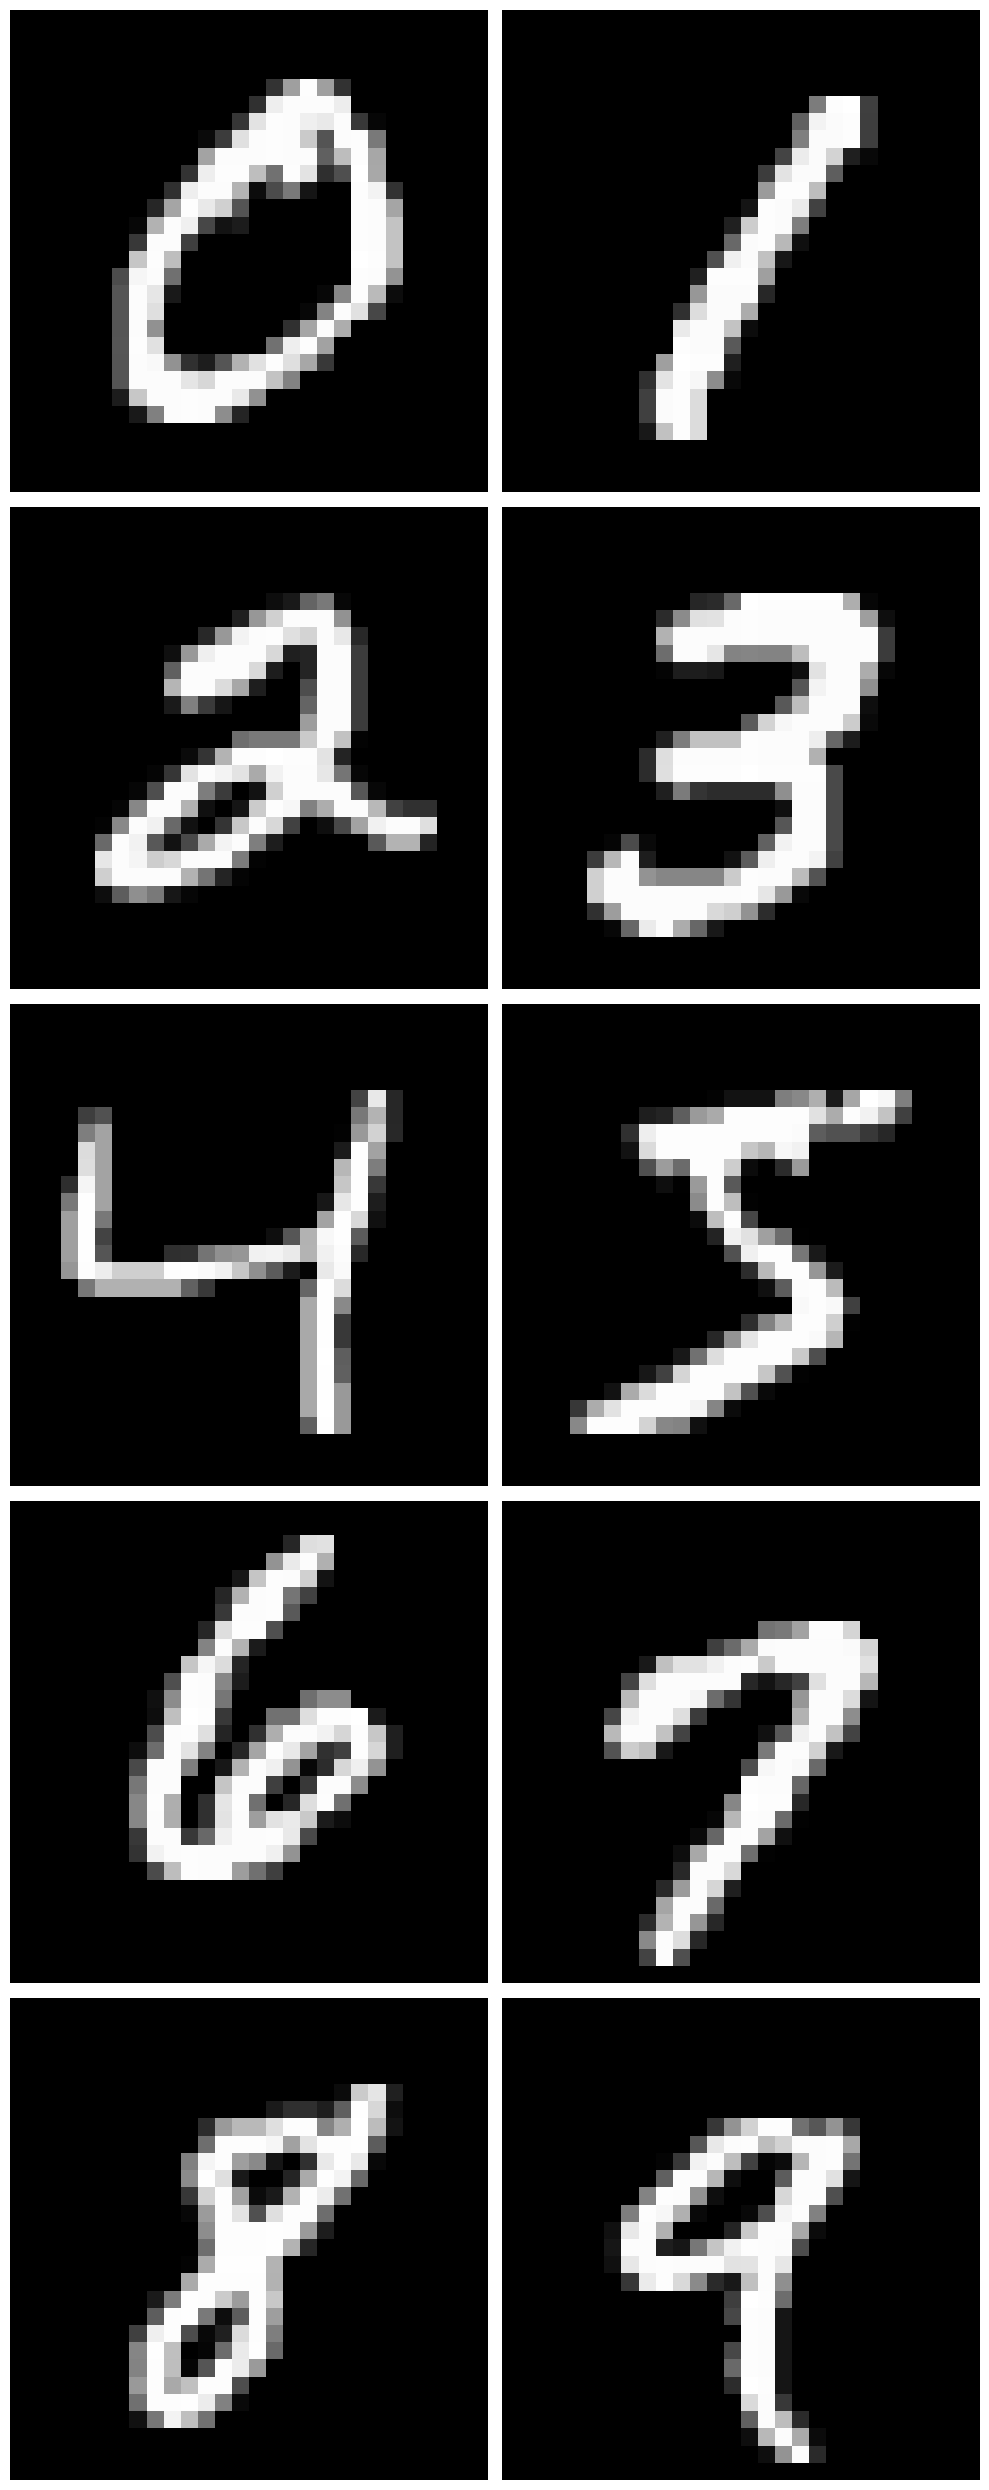

In [79]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Layer, Conv2D, Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense

class MaxPoolingWithArgmax2D(Layer):
    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(inputs, ksize, strides, 'SAME')
        argmax = tf.cast(argmax, tf.keras.backend.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]

class MaxUnpooling2D(Layer):
    def __init__(self, up_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.up_size = up_size

    def unpool(self, pool, ind, ksize=[1, 2, 2, 1]):
        input_shape = tf.shape(pool)
        output_shape = [input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3]]

        flat_input_size = tf.math.reduce_prod(input_shape)
        flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

        pool_ = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(tf.cast(output_shape[0], tf.int64), dtype=ind.dtype),
                                          shape=[input_shape[0], 1, 1, 1])
        b = tf.ones_like(ind) * batch_range
        b1 = tf.reshape(b, [flat_input_size, 1])
        ind_ = tf.reshape(ind, [flat_input_size, 1])
        ind_ = tf.concat([b1, ind_], 1)

        ret = tf.scatter_nd(ind_, pool_, shape=tf.cast(flat_output_shape, tf.int64))
        ret = tf.reshape(ret, output_shape)

        set_input_shape = pool.get_shape()
        set_output_shape = [set_input_shape[0], set_input_shape[1] * ksize[1], set_input_shape[2] * ksize[2], set_input_shape[3]]
        ret.set_shape(set_output_shape)
        return ret

    def call(self, inputs, output_shape=None):
        updates = inputs[0]
        mask    = tf.cast(inputs[1], dtype=tf.int64)
        ksize   = [1, self.up_size[0], self.up_size[1], 1]
        return self.unpool(updates, mask, ksize)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.up_size[0],
            mask_shape[2] * self.up_size[1],
            mask_shape[3]
        )
class Encoder(Model):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.input_1 = Input(shape=input_dim)
        self.conv1 = Conv2D(16, (5, 5), activation='relu', padding='same')
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.max_pool_argmax = MaxPoolingWithArgmax2D(pool_size=(7,7), strides=(7,7))

    def call(self, x):
        #x = self.input_1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x, mask_1 = self.max_pool_argmax(x)
        L2M_encoder_1 = x
        return x, mask_1, L2M_encoder_1

class Decoder(Model):
    def __init__(self, original_shape, latent_dim):
        super(Decoder, self).__init__()
        self.unpool_1 = MaxUnpooling2D((7,7))
        self.conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.conv_2 = Conv2D(1, (5, 5), activation='sigmoid', padding='same')
        self.dense = Dense(latent_dim, activation='linear')  # Add a dense layer for latent space

    def call(self, x):
        # The input x is expected to be a tuple of (feature_map, mask)
        feature_map, mask = x
        L2M_decoder_1 = feature_map  # This could be a part of the latent space pathway

        # Reconstruct the image
        x = self.unpool_1((feature_map, mask))
        x = self.conv_1(x)
        reconstructed = self.conv_2(x)

        # Flatten the feature_map for the dense layer to produce the latent space representation
        flattened = tf.reshape(feature_map, (tf.shape(feature_map)[0], -1))
        latent_representation = self.dense(flattened)  # This is the latent space representation

        # Return both the reconstructed image and the latent space representation
        return reconstructed, latent_representation, L2M_decoder_1


class SWWAE(Model):
    def __init__(self, input_dim, latent_dim):
        super(SWWAE, self).__init__()
        self.encoder = Encoder(input_dim)
        self.decoder = Decoder(input_dim, latent_dim)  # Pass latent_dim to the decoder
        self.latent_dim = latent_dim

    def compile(self, optimizer, loss):
        super().compile(optimizer)
        self.loss = loss

    def call(self, x):
        encoded, mask_1, L2M_encoder_1 = self.encoder(x)
        decoded, latent, L2M_decoder_1 = self.decoder([encoded, mask_1])
        return decoded, encoded, L2M_encoder_1, L2M_decoder_1  # Modified to return encoded


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train.astype('float32') / 255., -1)
x_test = np.expand_dims(x_test.astype('float32') / 255., -1)
print(len(x_train))
print(len(x_test))

x_train.shape

# class L2rec_L2M(Loss):
#     def __init__(self, L2rec_lambda=1, L2M_lambda=1):
#         self.L2rec_lambda = L2rec_lambda
#         self.L2M_lambda = L2M_lambda

def L2rec_L2M(y_true, y_pred, L2M_encoder_1, L2M_decoder_1):
    l2m_1 = tf.math.square(tf.math.subtract(L2M_encoder_1,L2M_decoder_1))
    L2rec = tf.math.square(tf.math.subtract(y_true,y_pred))
    return tf.math.add(tf.math.reduce_mean(l2m_1),tf.math.reduce_mean(L2rec))

input_dim = (28,28,1)
latent_dim = 2
model = SWWAE(input_dim,latent_dim)
optimizer = tf.optimizers.Adam()

loss = L2rec_L2M
model.compile(loss=loss, optimizer=optimizer)

# Commented out IPython magic to ensure Python compatibility.
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Randomly select a set of images for visualization
num_visualize = 10  # Number of images you want to visualize
# Identify indices for digits 0 through 9 in the training set
indices = []
for digit in range(10):
    indices.append(np.where(y_train == digit)[0][0])  # Get the index of the first occurrence of each digit

# Create the visualization set with one instance of each digit
visualization_set = x_train[indices]

num_images = len(visualization_set)
num_rows = 5
num_cols = 2

# Set the figure size based on the number of rows and columns
fig_width = 10
fig_height = 5 * num_rows  # Adjust this factor to control the vertical spacing

# Create the figure and iterate through images
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    ax.imshow(visualization_set[i].squeeze(), cmap='gray', aspect='auto')
    ax.axis('off')

# Remove any empty subplots
for i in range(num_images, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
"""
import os
save_dir = 'saved_plots'
os.makedirs(save_dir, exist_ok=True)

filename = os.path.join(save_dir,  'targets.png')
plt.savefig(filename, bbox_inches='tight', pad_inches=0)  # Save the figure before showing it
#plt.show()  # Show the figure after saving it
plt.close()
"""
# Verify if the visualization set contains the digits 0 through 9
assert np.all(np.sort(np.unique(y_train[indices])) == np.arange(10)), "Visualization set does not contain all digits 0-9"
loss_values = []
epochs = 1
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            prediction, encoded, L2M_encoder_1, L2M_decoder_1 = model(x_batch_train, training=True)  # Logits for this minibatch
#             print('L2M_encoder_1',L2M_encoder_1.shape)
#             print('L2M_decoder_1',L2M_decoder_1.shape)
            # Compute the loss value for this minibatch.
            loss_value = loss(x_batch_train, prediction, L2M_encoder_1, L2M_decoder_1)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights,unconnected_gradients=tf.UnconnectedGradients.ZERO)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        loss_values.append(loss_value.numpy())

        # Log every 200 batches.
        if step % 200 == 0:
          print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))
          print("Seen so far: %s samples" % ((step + 1) * batch_size))
          """
          # Predict on the visualization set

            predictions = model.predict(visualization_set)
            reconstructions = predictions[0]  # Assuming the decoded images are the first element

                    # Calculate the number of rows and columns

            num_images = len(reconstructions)
            num_rows = 5
            num_cols = 2

            # Set the figure size based on the number of rows and columns
            fig_width = 10
            fig_height = 5 * num_rows  # Adjust this factor to control the vertical spacing

            # Create the figure and iterate through images
            fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
            for i in range(num_images):
                row = i // num_cols
                col = i % num_cols
                ax = axs[row, col]
                ax.imshow(reconstructions[i].squeeze(), cmap='gray', aspect='auto')
                ax.axis('off')

            # Remove any empty subplots
            for i in range(num_images, num_rows * num_cols):
                fig.delaxes(axs.flatten()[i])

            plt.tight_layout()
            filename = os.path.join(save_dir, str(step) + '.png')
            plt.savefig(filename, bbox_inches='tight', pad_inches=0)  # Save the figure before showing it
            #plt.show()  # Show the figure after saving it
            plt.close()
        """

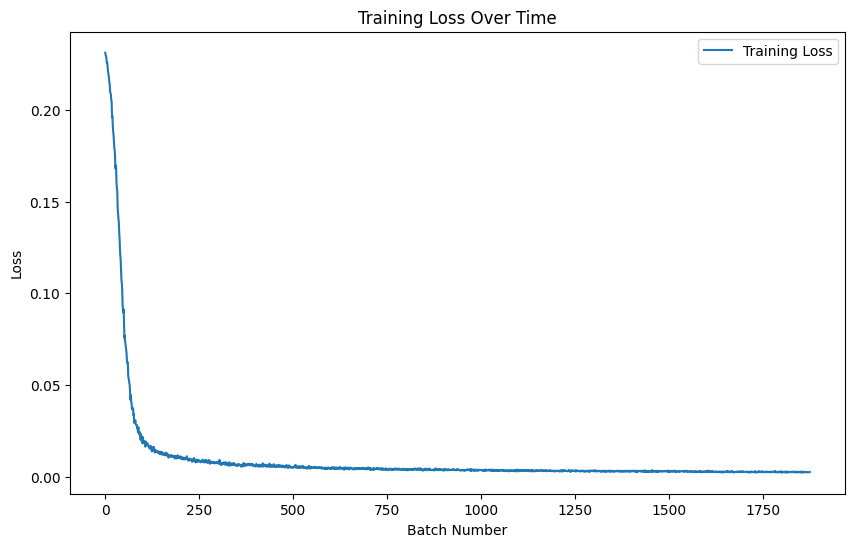

1/1 [==============================] - 1s 526ms/step


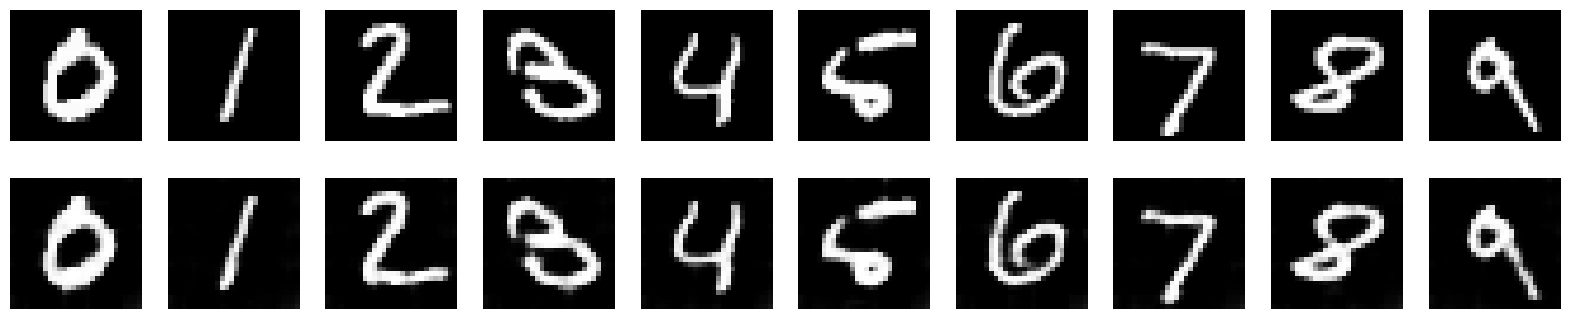

(10000, 4, 4, 32)


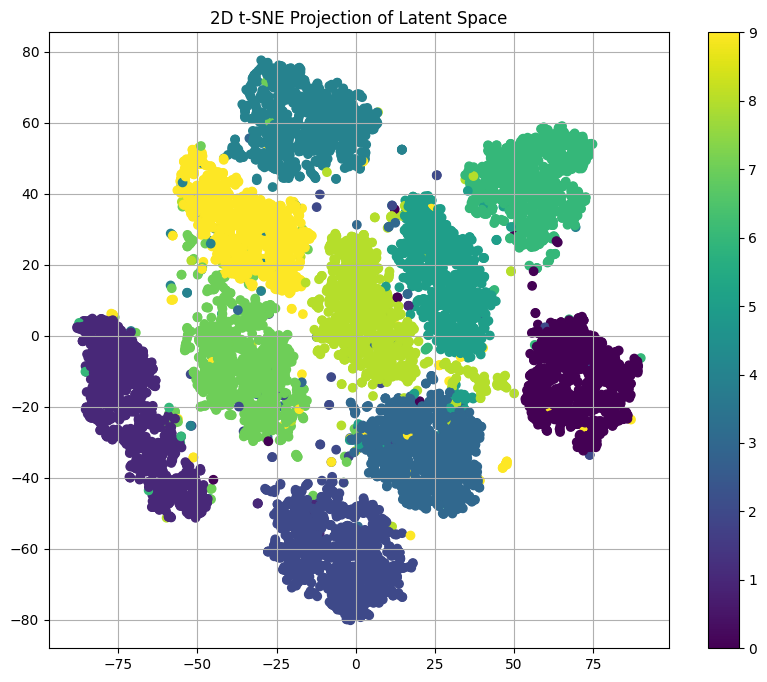

313/313 [==============================] - 4s 13ms/step


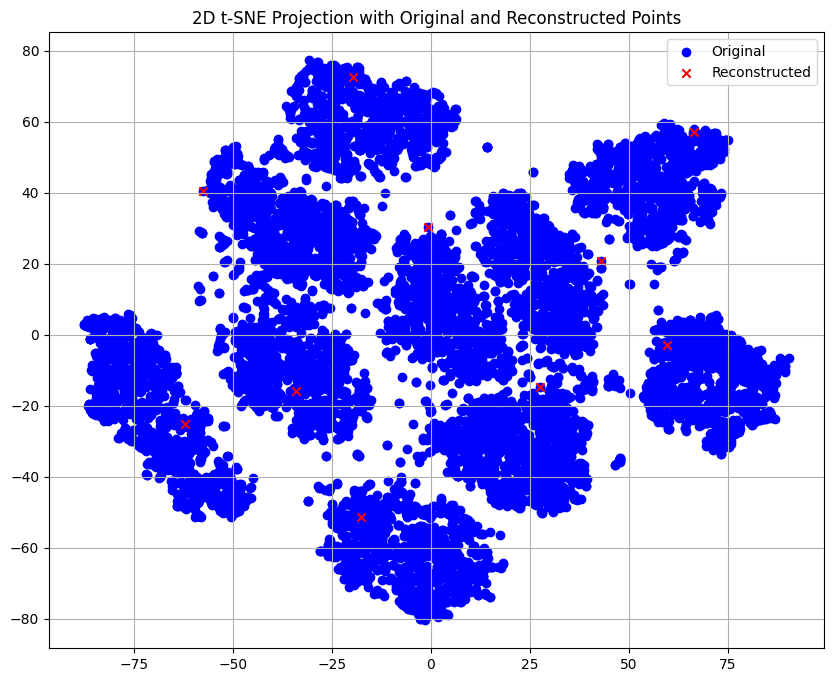

In [80]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_indices = []
for digit in range(10):
    test_indices.append(np.where(y_test == digit)[0][0])

# Get the test images for each digit
test_images = np.stack([x_test[idx] for idx in test_indices])

# Reconstruct the digits from the latent space
reconstructed_images, _, _, _ = model.predict(test_images)

# Plot the original and reconstructed images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i, (original, reconstructed) in enumerate(zip(test_images, reconstructed_images)):
    axs[0, i].imshow(original.squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(reconstructed.squeeze(), cmap='gray')
    axs[1, i].axis('off')
plt.show()


import tensorflow as tf
from sklearn.decomposition import PCA

decoded_images, latent_representations, a, b = model(x_test)

print(latent_representations.shape)

# Flatten the 4x4x32 representation to a 1D array per image
latent_flat = tf.reshape(latent_representations, [-1, 4*4*32])

from sklearn.manifold import TSNE

# Perform t-SNE on latent representations
tsne = TSNE(n_components=2)
latent_tsne = tsne.fit_transform(latent_flat)

# Plot the t-SNE projection
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title('2D t-SNE Projection of Latent Space')
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.manifold import TSNE

# Select specific test images
test_indices = [np.where(y_test == digit)[0][0] for digit in range(10)]
test_images = np.stack([x_test[idx] for idx in test_indices])

# Reconstruct the digits from the latent space
reconstructed_images, latent_reconstructed, _, _ = model.predict(test_images)

# Flatten the latent representations of the reconstructed images
latent_reconstructed_flat = tf.reshape(latent_reconstructed, [-1, 4*4*32])

# Get latent representations of all test images
decoded_images, latent_representations, _, _ = model.predict(x_test)
latent_flat = tf.reshape(latent_representations, [-1, 4*4*32])

# Combine original and reconstructed latent representations
combined_latent = np.vstack([latent_flat, latent_reconstructed_flat])

# Perform t-SNE on the combined data
tsne_combined = TSNE(n_components=2)
latent_tsne_combined = tsne_combined.fit_transform(combined_latent)

# Plot t-SNE projection with original and reconstructed points
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne_combined[:len(latent_flat), 0], latent_tsne_combined[:len(latent_flat), 1], c='blue', label='Original')
plt.scatter(latent_tsne_combined[len(latent_flat):, 0], latent_tsne_combined[len(latent_flat):, 1], c='red', marker='x', label='Reconstructed')
plt.title('2D t-SNE Projection with Original and Reconstructed Points')
plt.legend()
plt.grid(True)
plt.show()
